# MT Data-conditioned VAE

In [889]:
# pip install tensorflow

In [7]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

In [8]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [9]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    obs_xs = line[:,270:285]
    print(obs_xs.shape)
    obs_zs = -line[:,286:301]
    print(obs_zs.shape)
    obs_total = np.concatenate((obs_xs, obs_zs), axis=1)
    print(obs_total.shape)
    pred_zs = line[:,348:363]
    return line,cond, obs_total, pred_zs

In [10]:
line1,cond1, obs1, pred1 = import_file('Line1_Central-Copy1.csv')
line2,cond2, obs2, pred2 = import_file('Line2_Central-Copy1.csv')
line3,cond3, obs3, pred3 = import_file('Line3_Central-Copy1.csv')

print(obs1)

(16258, 15)
(16258, 15)
(16258, 30)
(3355, 15)
(3355, 15)
(3355, 30)
(17419, 15)
(17419, 15)
(17419, 30)
[[6.295087 5.203734 4.723107 ... 0.976215 0.582863 0.272842]
 [6.274186 5.188221 4.709166 ... 0.971868 0.579572 0.271219]
 [6.262685 5.180632 4.702812 ... 0.96766  0.576283 0.269532]
 ...
 [6.030007 5.631565 5.39819  ... 1.78922  1.159736 0.554354]
 [5.965578 5.573674 5.343903 ... 1.782502 1.155238 0.552165]
 [5.912551 5.526641 5.300363 ... 1.777644 1.151855 0.550477]]


In [11]:
print(len(cond1[:,0]))

16258


In [12]:
np.save('Line1_Central.npy', line1)
# np.save('Line1_Central_Conductivity.npy',cond1)
np.save('Line1_Central_Observations.npy',obs1)

In [13]:
np.save('Line2_Central.npy', line2)
# np.save('Line2_Central_Conductivity.npy',cond2)
np.save('Line2_Central_Observations.npy',obs2)

In [14]:
np.save('Line3_Central.npy', line3)
# np.save('Line3_Central_Conductivity.npy',cond3)
np.save('Line3_Central_Observations.npy',obs3)

In [15]:
data1 = np.load('Line1_Central.npy')
np.load('Line1_Central_Observations.npy')

array([[6.295087, 5.203734, 4.723107, ..., 0.976215, 0.582863, 0.272842],
       [6.274186, 5.188221, 4.709166, ..., 0.971868, 0.579572, 0.271219],
       [6.262685, 5.180632, 4.702812, ..., 0.96766 , 0.576283, 0.269532],
       ...,
       [6.030007, 5.631565, 5.39819 , ..., 1.78922 , 1.159736, 0.554354],
       [5.965578, 5.573674, 5.343903, ..., 1.782502, 1.155238, 0.552165],
       [5.912551, 5.526641, 5.300363, ..., 1.777644, 1.151855, 0.550477]])

In [16]:
data2 = np.load('Line2_Central.npy')
np.load('Line2_Central_Conductivity.npy')

array([[0.03648398, 0.04375333, 0.06125686, ..., 0.001001  , 0.00100172,
        0.00100138],
       [0.03692505, 0.04404815, 0.06117529, ..., 0.00100094, 0.00100167,
        0.00100133],
       [0.0355793 , 0.04299819, 0.06089889, ..., 0.00100111, 0.00100183,
        0.00100149],
       ...,
       [0.00886633, 0.01143951, 0.02004766, ..., 0.00100052, 0.00100119,
        0.00100088],
       [0.00974181, 0.01277133, 0.02308966, ..., 0.0010005 , 0.00100116,
        0.00100085],
       [0.01089706, 0.01448192, 0.02690818, ..., 0.00100052, 0.00100117,
        0.00100087]])

In [17]:
data3 = np.load('Line3_Central.npy')
np.load('Line3_Central_Conductivity.npy')

array([[0.04755097, 0.07919228, 0.2120686 , ..., 0.00100109, 0.00100129,
        0.0010012 ],
       [0.0492395 , 0.08198991, 0.2180947 , ..., 0.00100109, 0.00100129,
        0.00100119],
       [0.05325513, 0.08775873, 0.2287608 , ..., 0.00100107, 0.00100127,
        0.00100118],
       ...,
       [0.013676  , 0.01695183, 0.02671344, ..., 0.00100166, 0.00100244,
        0.00100208],
       [0.01278256, 0.01582356, 0.02485566, ..., 0.00100166, 0.00100244,
        0.00100208],
       [0.01163806, 0.01427949, 0.02214111, ..., 0.00100167, 0.00100249,
        0.0010021 ]])

In [18]:
print(len(cond1[0]))

30


In [19]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055,16.055])
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
16


In [20]:
depth = np.append(0,depths)
# print(depth)
cond1_new = np.zeros((len(cond1[:,0]),32))
for i in range(len(cond1[:,0])):
    x = cond1[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond1_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

cond2_new = np.zeros((len(cond2[:,0]),32))
for i in range(len(cond2[:,0])):
    x = cond2[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond2_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

cond3_new = np.zeros((len(cond3[:,0]),32))
for i in range(len(cond3[:,0])):
    x = cond3[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond3_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

obs1_new = np.zeros((len(obs1[:,0]),32))
for i in range(len(obs1[:,0])):
    x = obs1[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    obs1_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

obs2_new = np.zeros((len(obs2[:,0]),32))
for i in range(len(obs2[:,0])):
    x = obs2[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    obs2_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

obs3_new = np.zeros((len(obs3[:,0]),32))
for i in range(len(obs1[:,0])):
    x = obs3[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    obs3_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()
    
# print(len(cond1_new[0]))
# print(cond1_new[1])
depths=y
print(depths)
print(obs1_new.shape)


[  4.     8.4   13.24  18.56  24.42  30.86  37.95  45.74  54.31  63.74
  74.11  85.52  98.07 111.88 127.07 143.78 162.16 182.38 204.62 229.08
 255.99 285.59 318.15 353.97 393.37 436.71 484.38 536.82 554.   573.
 594.5 ]
(16258, 32)


In [21]:
np.save('Line1_Central_Conductivity.npy',cond1_new)
np.save('Line2_Central_Conductivity.npy',cond2_new)
np.save('Line3_Central_Conductivity.npy',cond3_new)

np.save('Line1_Central_Observations.npy',obs1_new)
np.save('Line2_Central_Observations.npy',obs2_new)
np.save('Line3_Central_Observations.npy',obs3_new)

In [22]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [23]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='mae',
                   data_loss_type='mae'
                  )


thicknesses (31,)


c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [24]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(1/np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw_log = preprocess('Line1_Central_Observations.npy')
x_validate_raw_log = preprocess('Line3_Central_Observations.npy')
x_test1_raw_log = preprocess('Line2_Central_Observations.npy')
#print(x_train_raw_log)

x_train_raw = network.model_to_tanhs(x_train_raw_log)
x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
x_test1_raw = network.model_to_tanhs(x_test1_raw_log)
# print(x_train_raw)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
# print(x_train)
# print(np.max(x_train))

[[[ 0.3717506 ]
  [ 0.35877268]
  [ 0.33019401]
  ...
  [ 0.5399025 ]
  [ 0.53984124]
  [ 0.53986997]]

 [[ 0.35924058]
  [ 0.3459848 ]
  [ 0.3168738 ]
  ...
  [ 0.53991749]
  [ 0.53985802]
  [ 0.53988592]]

 [[ 0.34984667]
  [ 0.33582953]
  [ 0.30524038]
  ...
  [ 0.53992124]
  [ 0.53986095]
  [ 0.53988923]]

 ...

 [[-0.06332845]
  [-0.10986223]
  [-0.13967353]
  ...
  [ 0.53997866]
  [ 0.53995864]
  [ 0.53996803]]

 [[-0.06540916]
  [-0.10690175]
  [-0.13454177]
  ...
  [ 0.53997788]
  [ 0.53995752]
  [ 0.53996707]]

 [[-0.0760605 ]
  [-0.10976947]
  [-0.12975373]
  ...
  [ 0.53997772]
  [ 0.5399577 ]
  [ 0.53996709]]]
0.5400728129689761


C:\Users\saraf\AppData\Local\Temp\ipykernel_11348\1457260169.py:8: RuntimeWarning: divide by zero encountered in divide
  x = np.log(1/np.load(filename))


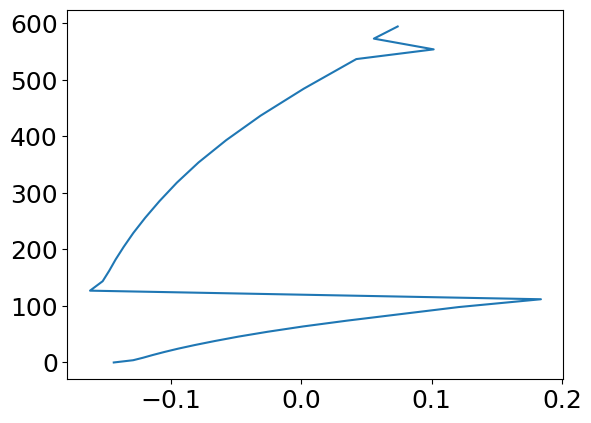

In [118]:
x_train1 = x_train[0:100,]
x_validate1 = x_validate[0:100,]
x_train_raw1 = x_train_raw[0:100,]
x_validate_raw1 = x_validate_raw[0:100,]
x_test_raw1 = x_test1_raw[0:100,]
plt.plot(x_train_raw1[0],np.append(0,depths))

In [156]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = x_train1[:,:,0]
# print(train_data)
print("train data", train_data.shape)
print('.........')

raw_train_data = x_train_raw1[:,:,0]
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data.shape)

validate_data = x_validate1[:,:,0]
raw_validate_data = x_validate_raw1[:,:,0]

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

train data (100, 32)
.........
raw_train_data (100, 32)


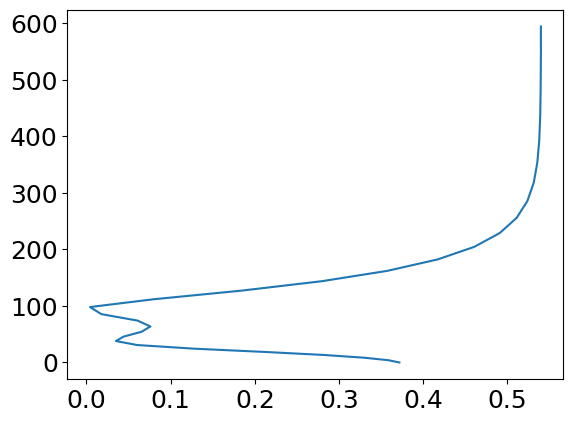

In [157]:
plt.plot(train_data[0],np.append(0,depths))
# plt.plot(obs1_new[0], np.append(0,depths), color='red')

In [158]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

(100, 32)
(100, 32)


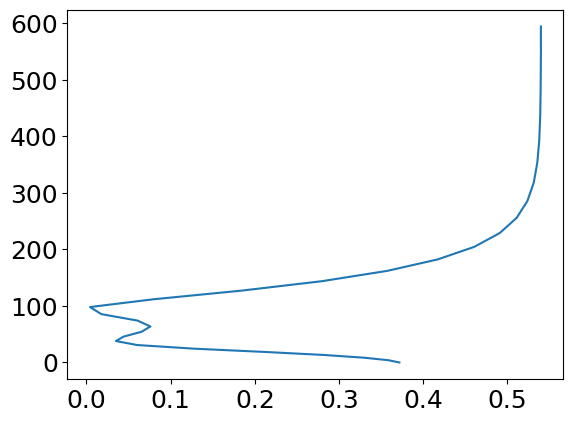

In [159]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')
print(train_data.shape)
print(raw_train_data.shape)

# plt.plot(x_train1[0],np.append(0,depths))
plt.plot(train_data[0],np.append(0,depths))

In [160]:
# # Create batches and shuffle
BATCH_SIZE = 8

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_data, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(validate_data, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
# print(mean_model_value, rel_model_std)
# print(rel_data_std, model_std_vec)

0.3091059569838888 0.1545529784919444
[0.242145   0.22330808 0.18613668 0.13428846 0.08007354 0.04507358
 0.04018411 0.05144381 0.05949135 0.05175151 0.02624362 0.00653643
 0.03519477 0.11107722 0.20194334 0.28611886 0.35652518 0.41217443
 0.45425335 0.48474665 0.50589887 0.51990764 0.5287324  0.53400179
 0.53697342 0.53855103 0.53933799 0.53970633 0.53986622 0.53992146
 0.53988267 0.53990086] [5.39596656e-02 5.47206057e-02 5.44002669e-02 4.96947757e-02
 3.65008072e-02 1.67927189e-02 6.24413659e-03 6.85181139e-03
 5.55039956e-03 1.33736534e-02 2.05905242e-02 1.44065177e-02
 2.76505762e-02 4.25062234e-02 4.05966306e-02 3.24290421e-02
 2.39663892e-02 1.68469574e-02 1.13394158e-02 7.31034685e-03
 4.50443860e-03 2.64407885e-03 1.47321926e-03 7.76157690e-04
 3.85372605e-04 1.80186312e-04 8.01228916e-05 3.60306691e-05
 2.20714646e-05 3.00553848e-05 2.38436439e-05 2.64681602e-05]


In [161]:
# plt.plot(train_dataset[0],np.append(0,depths))

In [162]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=1,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

thicknesses (31,)


"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [163]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, n_cells))
# print('i_random_train',i_random_train)
# print('random_train',random_train)
# predict their data
random_data = network.predict_tanh(random_train.reshape(16, n_cells, 1))
# print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
# print('random_log_data', random_log_data)
# print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
# print('n_data',network.n_data)
data_input = tf.reshape(random_data,(16,network.n_data))
# print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
# print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

i_random_train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
random_train [[ 3.71750602e-01  3.58772676e-01  3.30194010e-01  2.82490024e-01
   2.12936612e-01  1.27888156e-01  6.02049786e-02  3.49576498e-02
   4.40362114e-02  6.53828532e-02  7.59341185e-02  6.06357791e-02
   1.76675995e-02  4.19611529e-03  7.98784278e-02  1.83823370e-01
   2.79550958e-01  3.57563413e-01  4.17262398e-01  4.60768152e-01
   4.91039839e-01  5.11126956e-01  5.23797698e-01  5.31371287e-01
   5.35645945e-01  5.37917092e-01  5.39050902e-01  5.39582423e-01
   5.39815261e-01  5.39902501e-01  5.39841235e-01  5.39869971e-01]
 [ 3.59240576e-01  3.45984796e-01  3.16873801e-01  2.68490179e-01
   1.98700643e-01  1.15832258e-01  5.35029192e-02  3.38021340e-02
   4.67337210e-02  6.72045859e-02  7.43442646e-02  5.62247407e-02
   1.44325321e-02  7.50414536e-03  8.70015047e-02  1.90955564e-01
   2.85389842e-01  3.61932776e-01  4.20348794e-01  4.62848687e-01
   4.92383918e-01  5.11960888e-01  5.24296035e-01  5.31659321e-

In [164]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

52290

<Figure size 640x480 with 0 Axes>

In [165]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [166]:
epochs = 10

In [167]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        print(len(train_x[1]))
        # print(len(train_x[1]))
        train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=True)
        #train_losses.append(train_loss.numpy())
        train_terms.append([tt.numpy() for tt in train_term])
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, val_term[0], val_term[1], val_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))
# WHERE IS THE 35 COMING FROM????n

8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 1, Data misfit: 279.6, Reconstruction: 1.02e+09, KL: 0.0717, Elapsed 12.83 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 2, Data misfit: 279.6, Reconstruction: 1.02e+09, KL: 0.09178, Elapsed 11.08 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 3, Data misfit: 279.6, Reconstruction: 1.017e+09, KL: 0.02443, Elapsed 10.9 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 4, Data misfit: 279.6, Reconstruction: 1.022e+09, KL: 0.0854, Elapsed 10.95 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 5, Data misfit: 279.6, Reconstruction: 1.017e+09, KL: 0.07539, Elapsed 10.87 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 6, Data misfit: 279.6, Reconstruction: 1.019e+09, KL: 0.1216, Elapsed 10.85 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 7, Data misfit: 279.6, Reconstruction: 1.03e+09, KL: 0.06472, Elapsed 11.23 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 8, Data misfit: 279.6, Reconstruction: 1.023e+09, KL: 0.08328, Elapsed 11.25 s
8
8
8
8
8
8
8
8
8
8
8
8
4
Epoch: 9, Data misfit: 279.6, Reconstruction: 1.02e+09, KL: 0.09566, Elapsed 11.36 s


c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [168]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

In [169]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

In [170]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch,weighted=False)

In [171]:
plt.close('all')
plt.clf()
gc.collect()

26230

<Figure size 640x480 with 0 Axes>

# Load networks

In [172]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [173]:
loss_terms = np.load(run+'/losses.npy')

In [174]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [175]:
plt.rcParams.update({'font.size': 18})

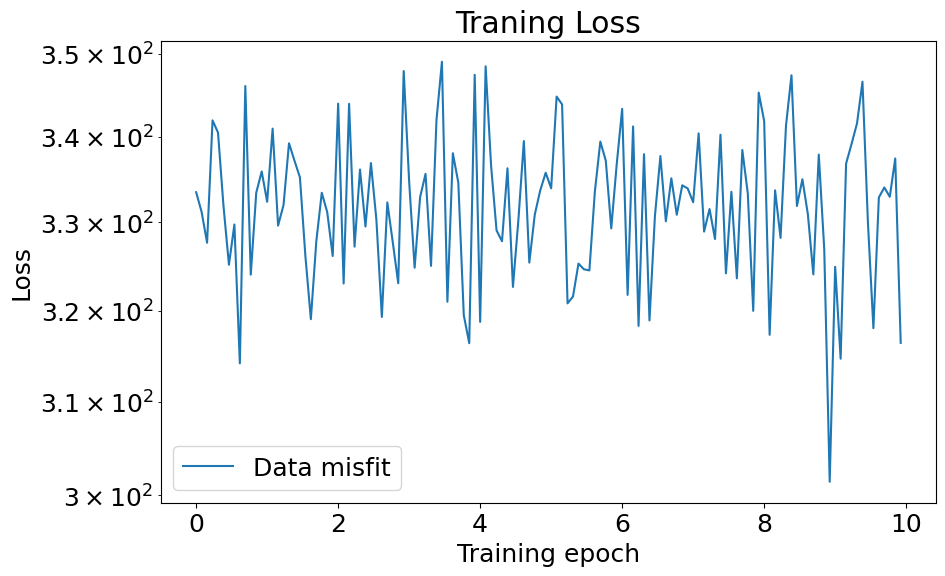

In [176]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt[:,0])
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

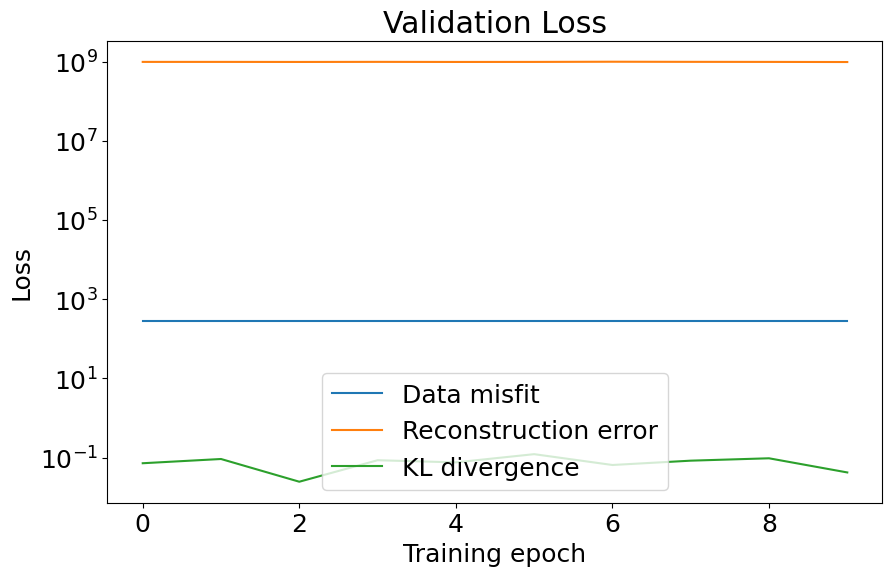

In [177]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

In [129]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=True)

In [130]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(zmd)
network.plot_models(latent=zmd)

tf.Tensor(
[[-5.36538780e-01 -2.60450912e+00 -7.38362670e-01 -1.43091726e+00
   1.81465715e-01 -1.56344986e+00 -7.19396889e-01  1.96396363e+00
   2.06890598e-01 -1.11117494e+00  2.77200198e+00 -3.84289354e-01
  -8.90760958e-01 -9.86144543e-01 -6.25514984e-03  3.93378288e-01
   1.20914769e+00 -4.37636599e-02 -4.79741812e-01  6.43645763e-01
   2.47180585e-13  4.00519292e-14  1.28066359e-14  4.03160620e-15
   1.24069882e-15  4.40701872e-16  1.73885832e-16  7.38443191e-17
   3.20544994e-17  1.36706510e-17  5.60453991e-18  2.20749897e-18
   8.41884523e-19  3.15775268e-19  1.06599502e-19  1.06599502e-19
  -2.44469618e-11 -2.11761359e-12 -4.69317402e-13 -9.66797782e-14
  -1.69835798e-14 -3.24866612e-15 -7.31088536e-16 -1.95595392e-16
  -5.61646702e-17 -1.60487564e-17 -4.39160941e-18 -1.14652878e-18
  -2.88263319e-19 -7.12792649e-20 -1.52884658e-20 -1.52884658e-20]
 [ 1.20192313e+00 -1.60704994e+00 -1.63685501e+00 -1.76345646e+00
  -8.94713759e-01 -1.30485761e+00  2.85120797e+00 -3.16986978e-0

In [131]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [132]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.18283556>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3353075>)

In [133]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.03254183984457575>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5399266299885006>)

In [134]:
network.plot_data(latent=zmd)

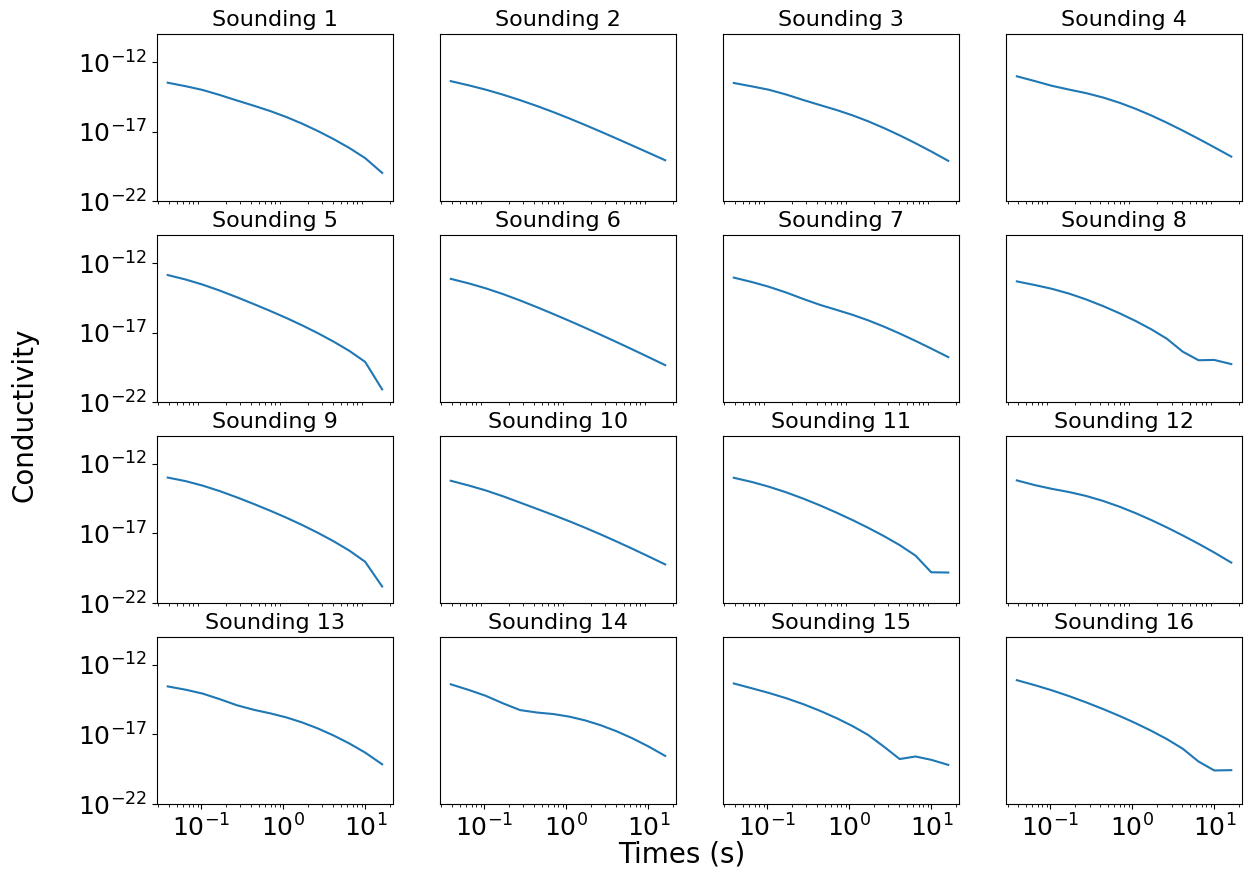

In [135]:
network.plot_residuals(latent=zmd, ylims=(1e-22, 1e-10), weighted=False)

# Randomize latent; does data still fit?

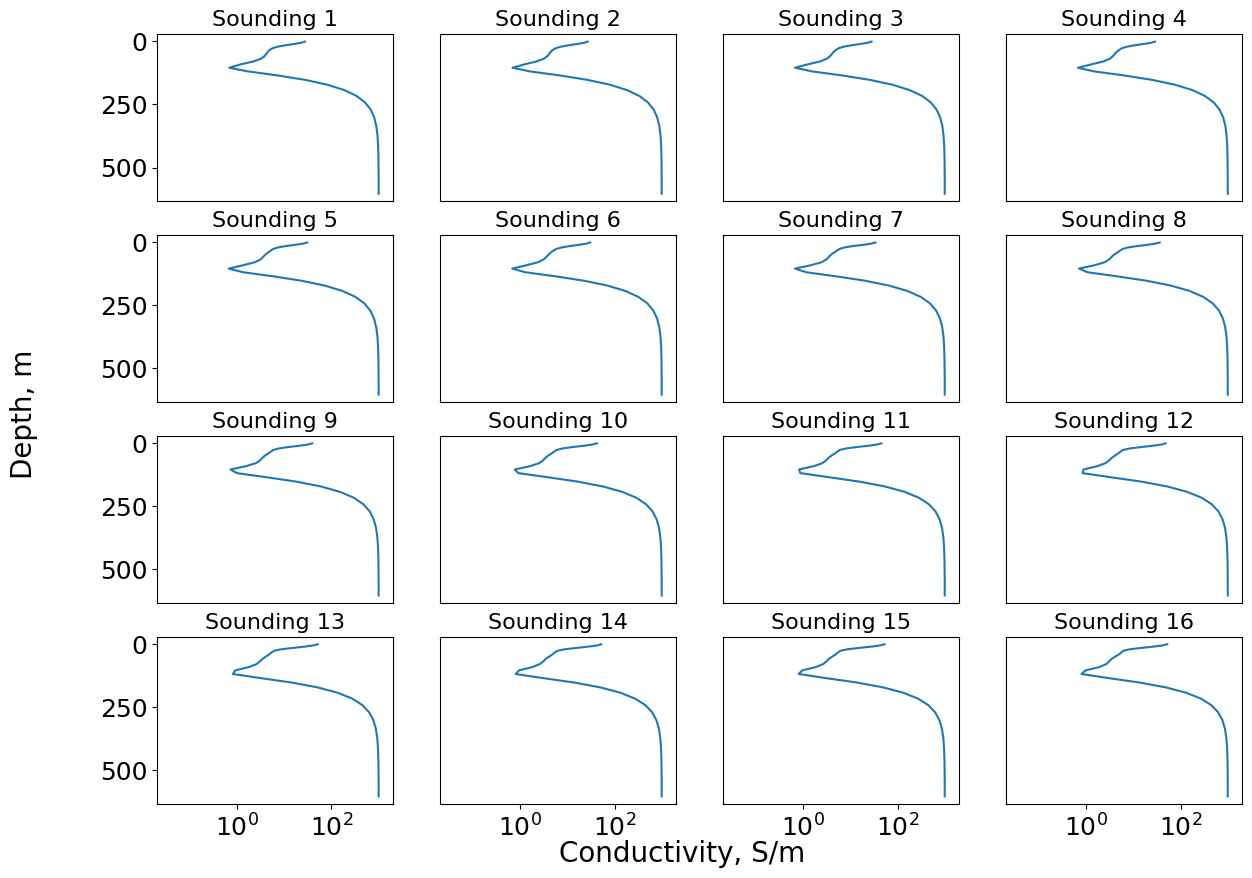

In [136]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0:16])), depths=depths)

In [137]:
print(x_test1[0:1].shape)

(1, 32, 1)


In [138]:
data0 = tf.tile(z_data[0:1],[16,1])
zmd2 = tf.concat((latent_input,data0),-1)

In [139]:
network.plot_models(latent=zmd2)

In [140]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

In [141]:
zmd2_logs.shape

(16, 32)

In [142]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [143]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
std_cond = np.std((zmd2_logs),axis=0)
uncertainty = np.mean(mean_cond+std_cond**2)
print(uncertainty)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

23.247566


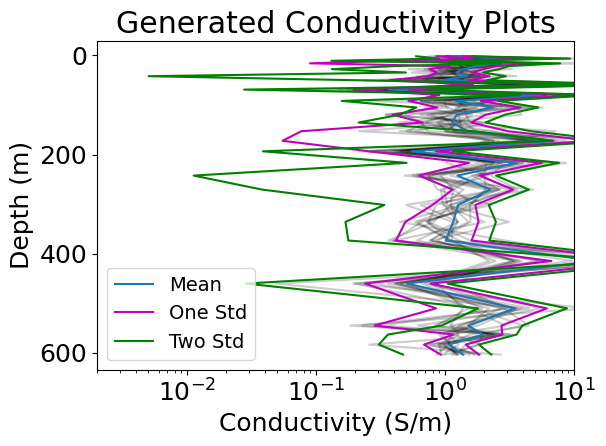

In [144]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond),plot_depths, c='m', label="One Std")
ax.semilogx(np.abs(mean_cond-std_cond), plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-3, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()

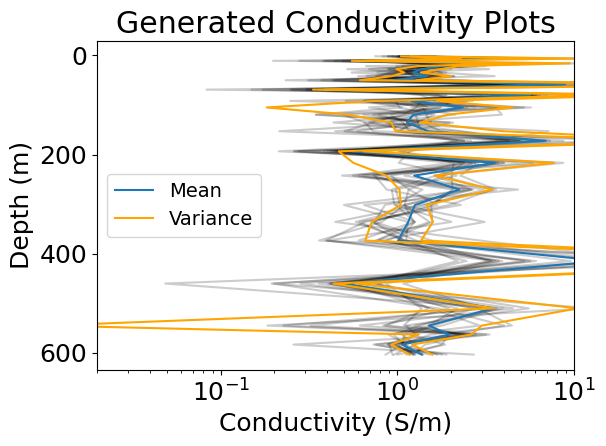

In [145]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond**2), plot_depths, c='orange', label='Variance')
ax.semilogx(np.abs(mean_cond-std_cond**2), plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-2, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

In [75]:
network.plot_data(latent=zmd2)

In [76]:
#log_data_test[0]

In [77]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1., -1.], dtype=float32)>

In [951]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

tanhs (16, 32, 1)
d_res (16, 32)
d_res tf.Tensor(
[[-4.55605866e-24 -3.59171020e-26 -3.84018298e-27 -5.34866905e-28
  -6.15767590e-29 -6.64190043e-30 -7.50735956e-31 -1.05449084e-31
  -1.72669408e-32 -2.95068147e-33 -4.87990363e-34 -7.56242352e-35
  -1.07642078e-35 -1.37060765e-36 -1.08548962e-37 -1.08548962e-37
  -1.04844600e-19 -1.20483357e-22 -4.00613032e-24 -2.25670524e-25
  -1.14442085e-26 -4.65347575e-28 -1.67716194e-29 -7.98012552e-31
  -5.01374672e-32 -3.53504800e-33 -2.48548431e-34 -1.67379490e-35
  -1.06530108e-36 -6.42824203e-38 -0.00000000e+00 -0.00000000e+00]
 [-2.25838117e-24 -7.75211994e-27 -1.66293785e-27 -4.06116514e-28
  -6.05244670e-29 -7.45712777e-30 -9.17744645e-31 -1.34094377e-31
  -2.17561479e-32 -3.49407431e-33 -5.04163466e-34 -5.85900593e-35
  -3.51212371e-36 -7.48898741e-37 -3.56730949e-37 -3.56730949e-37
  -7.17824751e-20 -2.29770206e-23 -3.27325408e-25 -1.03239774e-25
  -9.52377519e-27 -4.79689542e-28 -1.95346849e-29 -1.00258760e-30
  -6.49200845e-32 -4.4979

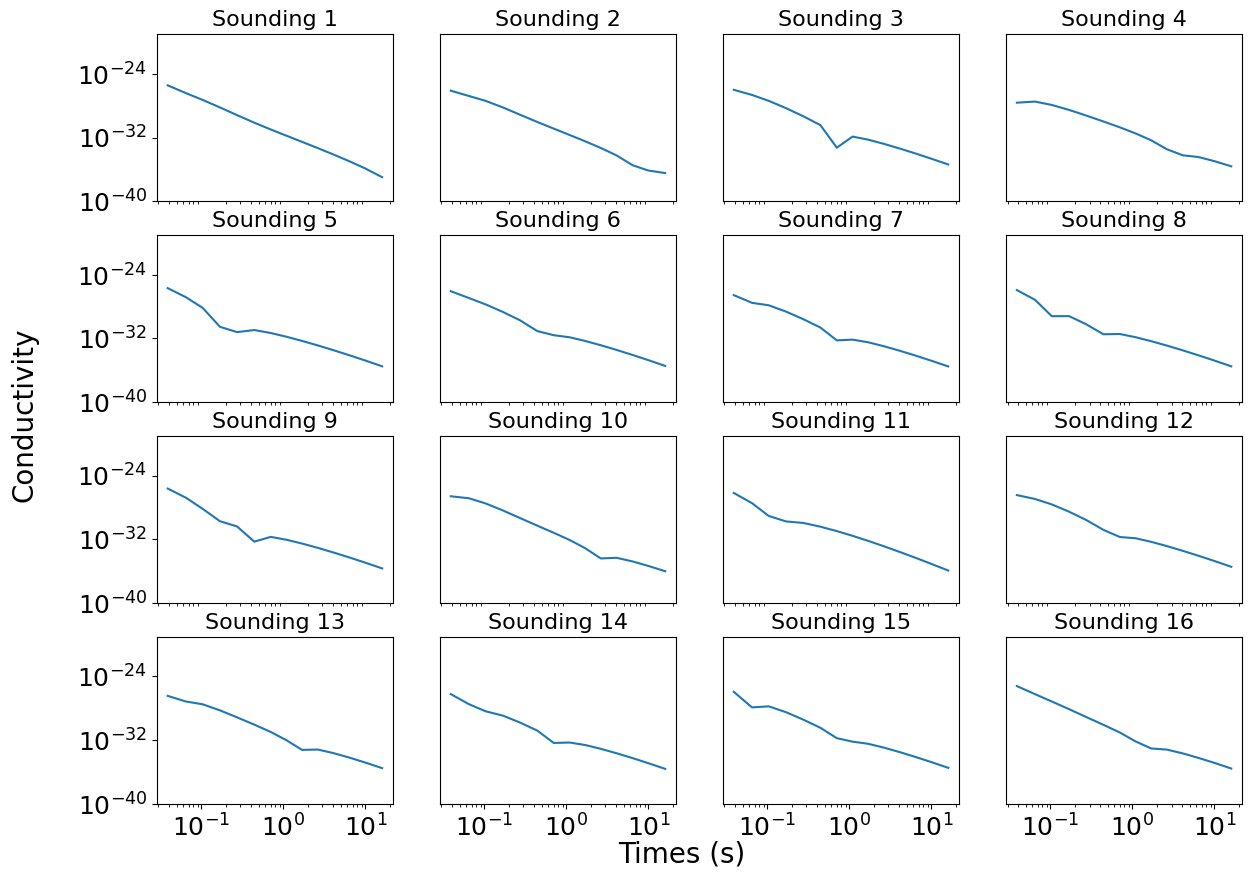

In [952]:
network.plot_residuals(latent=zmd2, ylims=(1e-40, 1e-19), weighted=True)

In [953]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [954]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [955]:
network.data_weights

array([[[1.15435682e+24],
        [5.00322554e+25],
        [4.15943531e+26],
        [3.47459359e+27],
        [3.28333887e+28],
        [2.53007943e+29],
        [1.37277259e+30],
        [5.10365685e+30],
        [1.56475258e+31],
        [4.50981073e+31],
        [1.29805702e+32],
        [3.81233616e+32],
        [1.14730124e+33],
        [3.53245540e+33],
        [1.25480450e+34],
        [1.25480450e+34],
        [8.59073504e+19],
        [1.97322470e+22],
        [3.67683133e+23],
        [6.97555787e+24],
        [1.81656028e+26],
        [4.91770275e+27],
        [1.11126464e+29],
        [1.44383099e+30],
        [1.23604493e+31],
        [8.91822836e+31],
        [6.19466434e+32],
        [4.29954650e+33],
        [3.00058121e+34],
        [2.08297990e+35],
        [1.74582901e+36],
        [1.74582901e+36]]], dtype=float32)

In [956]:
print(cond2[0])
print(cond2[1])

[3.648398e-02 4.375333e-02 6.125686e-02 9.333318e-02 1.370639e-01
 1.768252e-01 2.043877e-01 2.243076e-01 2.409013e-01 2.620672e-01
 3.102367e-01 4.454715e-01 8.480549e-01 1.465697e+00 5.938051e-01
 1.385875e-01 3.616845e-02 1.220992e-02 5.347820e-03 2.938946e-03
 1.941052e-03 1.475557e-03 1.242081e-03 1.121129e-03 1.058532e-03
 1.026996e-03 1.011817e-03 1.004928e-03 1.002029e-03 1.001002e-03]
[3.692505e-02 4.404815e-02 6.117529e-02 9.257349e-02 1.356392e-01
 1.754015e-01 2.036590e-01 2.246761e-01 2.426639e-01 2.649555e-01
 3.129994e-01 4.433329e-01 8.184385e-01 1.454583e+00 6.258761e-01
 1.456389e-01 3.750132e-02 1.251276e-02 5.433118e-03 2.967756e-03
 1.952150e-03 1.480173e-03 1.244037e-03 1.121919e-03 1.058802e-03
 1.027046e-03 1.011785e-03 1.004876e-03 1.001975e-03 1.000939e-03]


In [957]:
# num_plots = 4
# fig = plt.figure(figsize=(8, 10))
# for i in range(0, num_plots):
#     ax = plt.subplot(int(num_plots),2,i+1)
#     ax.plot(times, -obs2[i], -pred2[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('dB/dt')
#     plt.legend(['Observed','Predicted'])
# plt.tight_layout()
# plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [958]:
# print(len(cond2))

In [959]:
# depths1 = np.append(depths,[652])
# fig, ax = plt.subplots()
# ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
# ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
# ax.invert_yaxis()
# # ax.axes.set_xlim(1e-2, 1e4)
# plt.xlabel('Conductivity')
# plt.ylabel('Depth')
# plt.tight_layout()
# plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
# plt.show()